# Reintento de parcial Dataset Inmobiliaria

## Importar librerías y dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/carlos-paezf/Deep_Learning/master/Primer_Corte/data_inmueble.csv", encoding='utf-8')

## Conocer la data

El dataset base se encuentra en el [repositorio del docente](https://github.com/luisFernandoCastellanosG/Machine_learning/blob/master/Databasets/data_inmobiliaria.csv). Algunos cambios realizados son los siguientes:

- Cambio en el formato de las fechas, de ***'00/00/0000'*** a ***00000000***
- En el indice 201, se cambio el dato de ***BOGOTA- D.C.*** a ***BOGOTA***

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6791 entries, 0 to 6790
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   COD_INMUEBLE          6791 non-null   int64  
 1   NOM_SUCURSAL          6791 non-null   object 
 2   NOM_BARRIO            6791 non-null   object 
 3   NOM_CIUDAD            6791 non-null   object 
 4   ESTRATO               6734 non-null   object 
 5   TIPO_INMUEBLE         6791 non-null   object 
 6   AREA                  6791 non-null   int64  
 7   VLR_CANON             6791 non-null   int64  
 8   VLR_ADMINISTRACION    6791 non-null   int64  
 9   FECHA_CONSIGNACION    6791 non-null   int64  
 10  FECHA_RECONSIGNACION  383 non-null    float64
 11  FECHA_CONTRATO        6791 non-null   int64  
 12  COD_ESTADO_CONTRATO   6791 non-null   object 
dtypes: float64(1), int64(6), object(6)
memory usage: 689.8+ KB


In [6]:
data.describe()

,COD_INMUEBLE,AREA,VLR_CANON,VLR_ADMINISTRACION,FECHA_CONSIGNACION,FECHA_RECONSIGNACION,FECHA_CONTRATO
count,6791.000000,6791.000000,6.791000e+03,6.791000e+03,6.791000e+03,3.830000e+02,6.791000e+03
mean,3396.000000,46.357385,1.112686e+06,1.474904e+05,1.574091e+07,1.881163e+07,1.639169e+07
std,1960.537171,26.973165,1.427193e+06,1.583145e+05,9.804221e+06,7.547198e+06,9.767587e+06
min,1.000000,10.000000,0.000000e+00,0.000000e+00,1.012018e+06,3.072020e+06,1.190000e+04
25%,1698.500000,23.000000,6.539400e+05,0.000000e+00,7.092011e+06,1.307202e+07,7.122013e+06
50%,3396.000000,39.000000,8.123400e+05,1.480000e+05,1.512202e+07,2.101202e+07,1.702202e+07
75%,5093.500000,70.000000,1.052160e+06,2.300000e+05,2.505201e+07,2.504202e+07,2.601200e+07
max,6791.000000,100.000000,2.931983e+07,5.116724e+06,3.112202e+07,3.107202e+07,3.110202e+07


In [7]:
data.isnull().sum()

COD_INMUEBLE               0
NOM_SUCURSAL               0
NOM_BARRIO                 0
NOM_CIUDAD                 0
ESTRATO                   57
TIPO_INMUEBLE              0
AREA                       0
VLR_CANON                  0
VLR_ADMINISTRACION         0
FECHA_CONSIGNACION         0
FECHA_RECONSIGNACION    6408
FECHA_CONTRATO             0
COD_ESTADO_CONTRATO        0
dtype: int64

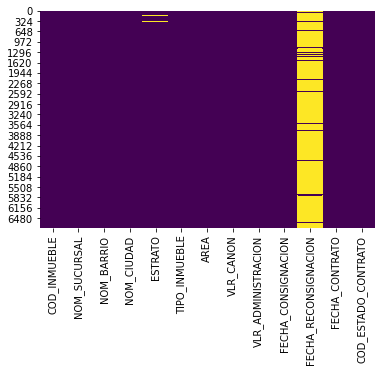

In [8]:
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')

## Eliminar columna con multiples datos nulos

La columna FECHA_RECONSIGNACION presenta un porcentaje de datos nulos mayor al 50%, por lo tanto para evitar sesgos en los resultados, se decide eliminar dicha columna

In [9]:
data.drop(labels=['FECHA_RECONSIGNACION'], inplace=True, axis=1)

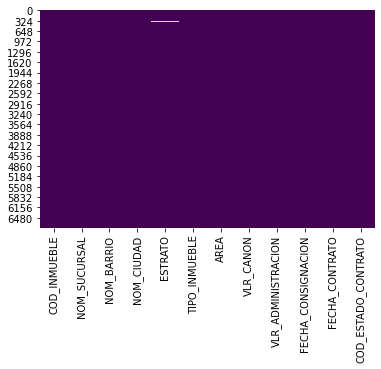

In [10]:
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')

## Normalizar - Imputar Datos

Para normalizar los datos de la columna ESTRATO, decidí usar un diccionario, pues si aplicaba LabelEnconder el orden de los datos serían contradictorios.

In [11]:
estrato = {'SIN ASIGNAR':0, 'UNO':1, 'DOS':2, 'TRES':3, 'CUATRO':4, 'CINCO':5, 'SEIS':6, 'COMERCIAL':7}
data['ESTRATO'] = data['ESTRATO'].map(estrato)

Como los demás datos no presentan conflictos, entonces procedo a normalizarlos con LabelEncoder

In [12]:
label_encoder = LabelEncoder()

captura_caracteristicas = [x for x in data.columns if data[x].dtype=='object']

for col in captura_caracteristicas:
    if col in data.columns:
        i = data.columns.get_loc(col)
        data.iloc[:, i] = data.apply(lambda i:label_encoder.fit_transform(i.astype(str)), axis=0, result_type='expand')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6791 entries, 0 to 6790
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   COD_INMUEBLE         6791 non-null   int64  
 1   NOM_SUCURSAL         6791 non-null   int64  
 2   NOM_BARRIO           6791 non-null   int64  
 3   NOM_CIUDAD           6791 non-null   int64  
 4   ESTRATO              6734 non-null   float64
 5   TIPO_INMUEBLE        6791 non-null   int64  
 6   AREA                 6791 non-null   int64  
 7   VLR_CANON            6791 non-null   int64  
 8   VLR_ADMINISTRACION   6791 non-null   int64  
 9   FECHA_CONSIGNACION   6791 non-null   int64  
 10  FECHA_CONTRATO       6791 non-null   int64  
 11  COD_ESTADO_CONTRATO  6791 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 636.8 KB


In [14]:
def imp_estrato(cols):
    estrato = cols[0]
    inmueble = cols[1]

    if pd.isnull(estrato):
        if inmueble == 0:
            return data[data['TIPO_INMUEBLE']==0]['ESTRATO'].mean()
        elif inmueble == 1:
            return data[data['TIPO_INMUEBLE']==0]['ESTRATO'].mean()
        elif inmueble == 2:
            return data[data['TIPO_INMUEBLE']==0]['ESTRATO'].mean()
    else:
        return estrato

In [15]:
data['ESTRATO'] = data[['ESTRATO', 'TIPO_INMUEBLE']].apply(imp_estrato, axis=1)

In [16]:
data['ESTRATO'] = data['ESTRATO'].astype('int')

In [17]:
data.isnull().sum()

COD_INMUEBLE           0
NOM_SUCURSAL           0
NOM_BARRIO             0
NOM_CIUDAD             0
ESTRATO                0
TIPO_INMUEBLE          0
AREA                   0
VLR_CANON              0
VLR_ADMINISTRACION     0
FECHA_CONSIGNACION     0
FECHA_CONTRATO         0
COD_ESTADO_CONTRATO    0
dtype: int64

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6791 entries, 0 to 6790
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   COD_INMUEBLE         6791 non-null   int64
 1   NOM_SUCURSAL         6791 non-null   int64
 2   NOM_BARRIO           6791 non-null   int64
 3   NOM_CIUDAD           6791 non-null   int64
 4   ESTRATO              6791 non-null   int64
 5   TIPO_INMUEBLE        6791 non-null   int64
 6   AREA                 6791 non-null   int64
 7   VLR_CANON            6791 non-null   int64
 8   VLR_ADMINISTRACION   6791 non-null   int64
 9   FECHA_CONSIGNACION   6791 non-null   int64
 10  FECHA_CONTRATO       6791 non-null   int64
 11  COD_ESTADO_CONTRATO  6791 non-null   int64
dtypes: int64(12)
memory usage: 636.8 KB


## Dejar solo 2 estados en el COD_ESTADO_CONTRATO

In [19]:
cod_estado = {0:0, 1:data['COD_ESTADO_CONTRATO'].mode(), 2:1}
data['COD_ESTADO_CONTRATO'] = data['COD_ESTADO_CONTRATO'].map(cod_estado).astype('int')

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6791 entries, 0 to 6790
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   COD_INMUEBLE         6791 non-null   int64
 1   NOM_SUCURSAL         6791 non-null   int64
 2   NOM_BARRIO           6791 non-null   int64
 3   NOM_CIUDAD           6791 non-null   int64
 4   ESTRATO              6791 non-null   int64
 5   TIPO_INMUEBLE        6791 non-null   int64
 6   AREA                 6791 non-null   int64
 7   VLR_CANON            6791 non-null   int64
 8   VLR_ADMINISTRACION   6791 non-null   int64
 9   FECHA_CONSIGNACION   6791 non-null   int64
 10  FECHA_CONTRATO       6791 non-null   int64
 11  COD_ESTADO_CONTRATO  6791 non-null   int64
dtypes: int64(12)
memory usage: 636.8 KB


## Estarización de los datos

### Estandarización con MinMaxScaler

In [21]:
data[['AREA', 'VLR_CANON', 'VLR_ADMINISTRACION', 'FECHA_CONSIGNACION', 'FECHA_CONTRATO']] = MinMaxScaler().fit_transform(data[['AREA', 'VLR_CANON', 'VLR_ADMINISTRACION', 'FECHA_CONSIGNACION', 'FECHA_CONTRATO']])

In [22]:
data.head()

,COD_INMUEBLE,NOM_SUCURSAL,NOM_BARRIO,NOM_CIUDAD,ESTRATO,TIPO_INMUEBLE,AREA,VLR_CANON,VLR_ADMINISTRACION,FECHA_CONSIGNACION,FECHA_CONTRATO,COD_ESTADO_CONTRATO
0,1,0,81,0,4,0,0.144444,0.021576,0.032716,0.301561,0.388552,1
1,2,0,62,0,3,2,0.011111,0.017053,0.000000,0.333112,0.839499,1
2,3,0,62,0,3,0,0.155556,0.017053,0.000000,0.333112,0.709232,0
3,4,0,62,0,3,2,0.111111,0.017596,0.000000,0.333112,0.579931,0
4,5,0,237,0,3,0,0.255556,0.024864,0.052964,0.700100,0.774848,1


### Estandarización con StandardScaler

In [ ]:
data[['AREA', 'VLR_CANON', 'VLR_ADMINISTRACION', 'FECHA_CONSIGNACION', 'FECHA_CONTRATO']] = StandardScaler().fit_transform(data[['AREA', 'VLR_CANON', 'VLR_ADMINISTRACION', 'FECHA_CONSIGNACION', 'FECHA_CONTRATO']])

In [ ]:
data.head()

,COD_INMUEBLE,NOM_SUCURSAL,NOM_BARRIO,NOM_CIUDAD,ESTRATO,TIPO_INMUEBLE,AREA,VLR_CANON,VLR_ADMINISTRACION,FECHA_CONSIGNACION,FECHA_CONTRATO,COD_ESTADO_CONTRATO
0,1,0,81,0,4,0,-0.866013,-0.336409,0.125769,-0.576212,-0.440231,1
1,2,0,62,0,3,2,-1.310932,-0.429326,-0.931698,-0.479308,0.995235,1
2,3,0,62,0,3,0,-0.828936,-0.429326,-0.931698,-0.479308,0.580567,0
3,4,0,62,0,3,2,-0.977243,-0.418184,-0.931698,-0.479308,0.168972,0
4,5,0,237,0,3,0,-0.495247,-0.268859,0.780210,0.647841,0.789437,1


## Separación de los datos

In [23]:
X = data.drop(columns=['COD_ESTADO_CONTRATO'])
y = data['COD_ESTADO_CONTRATO']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Gráficas

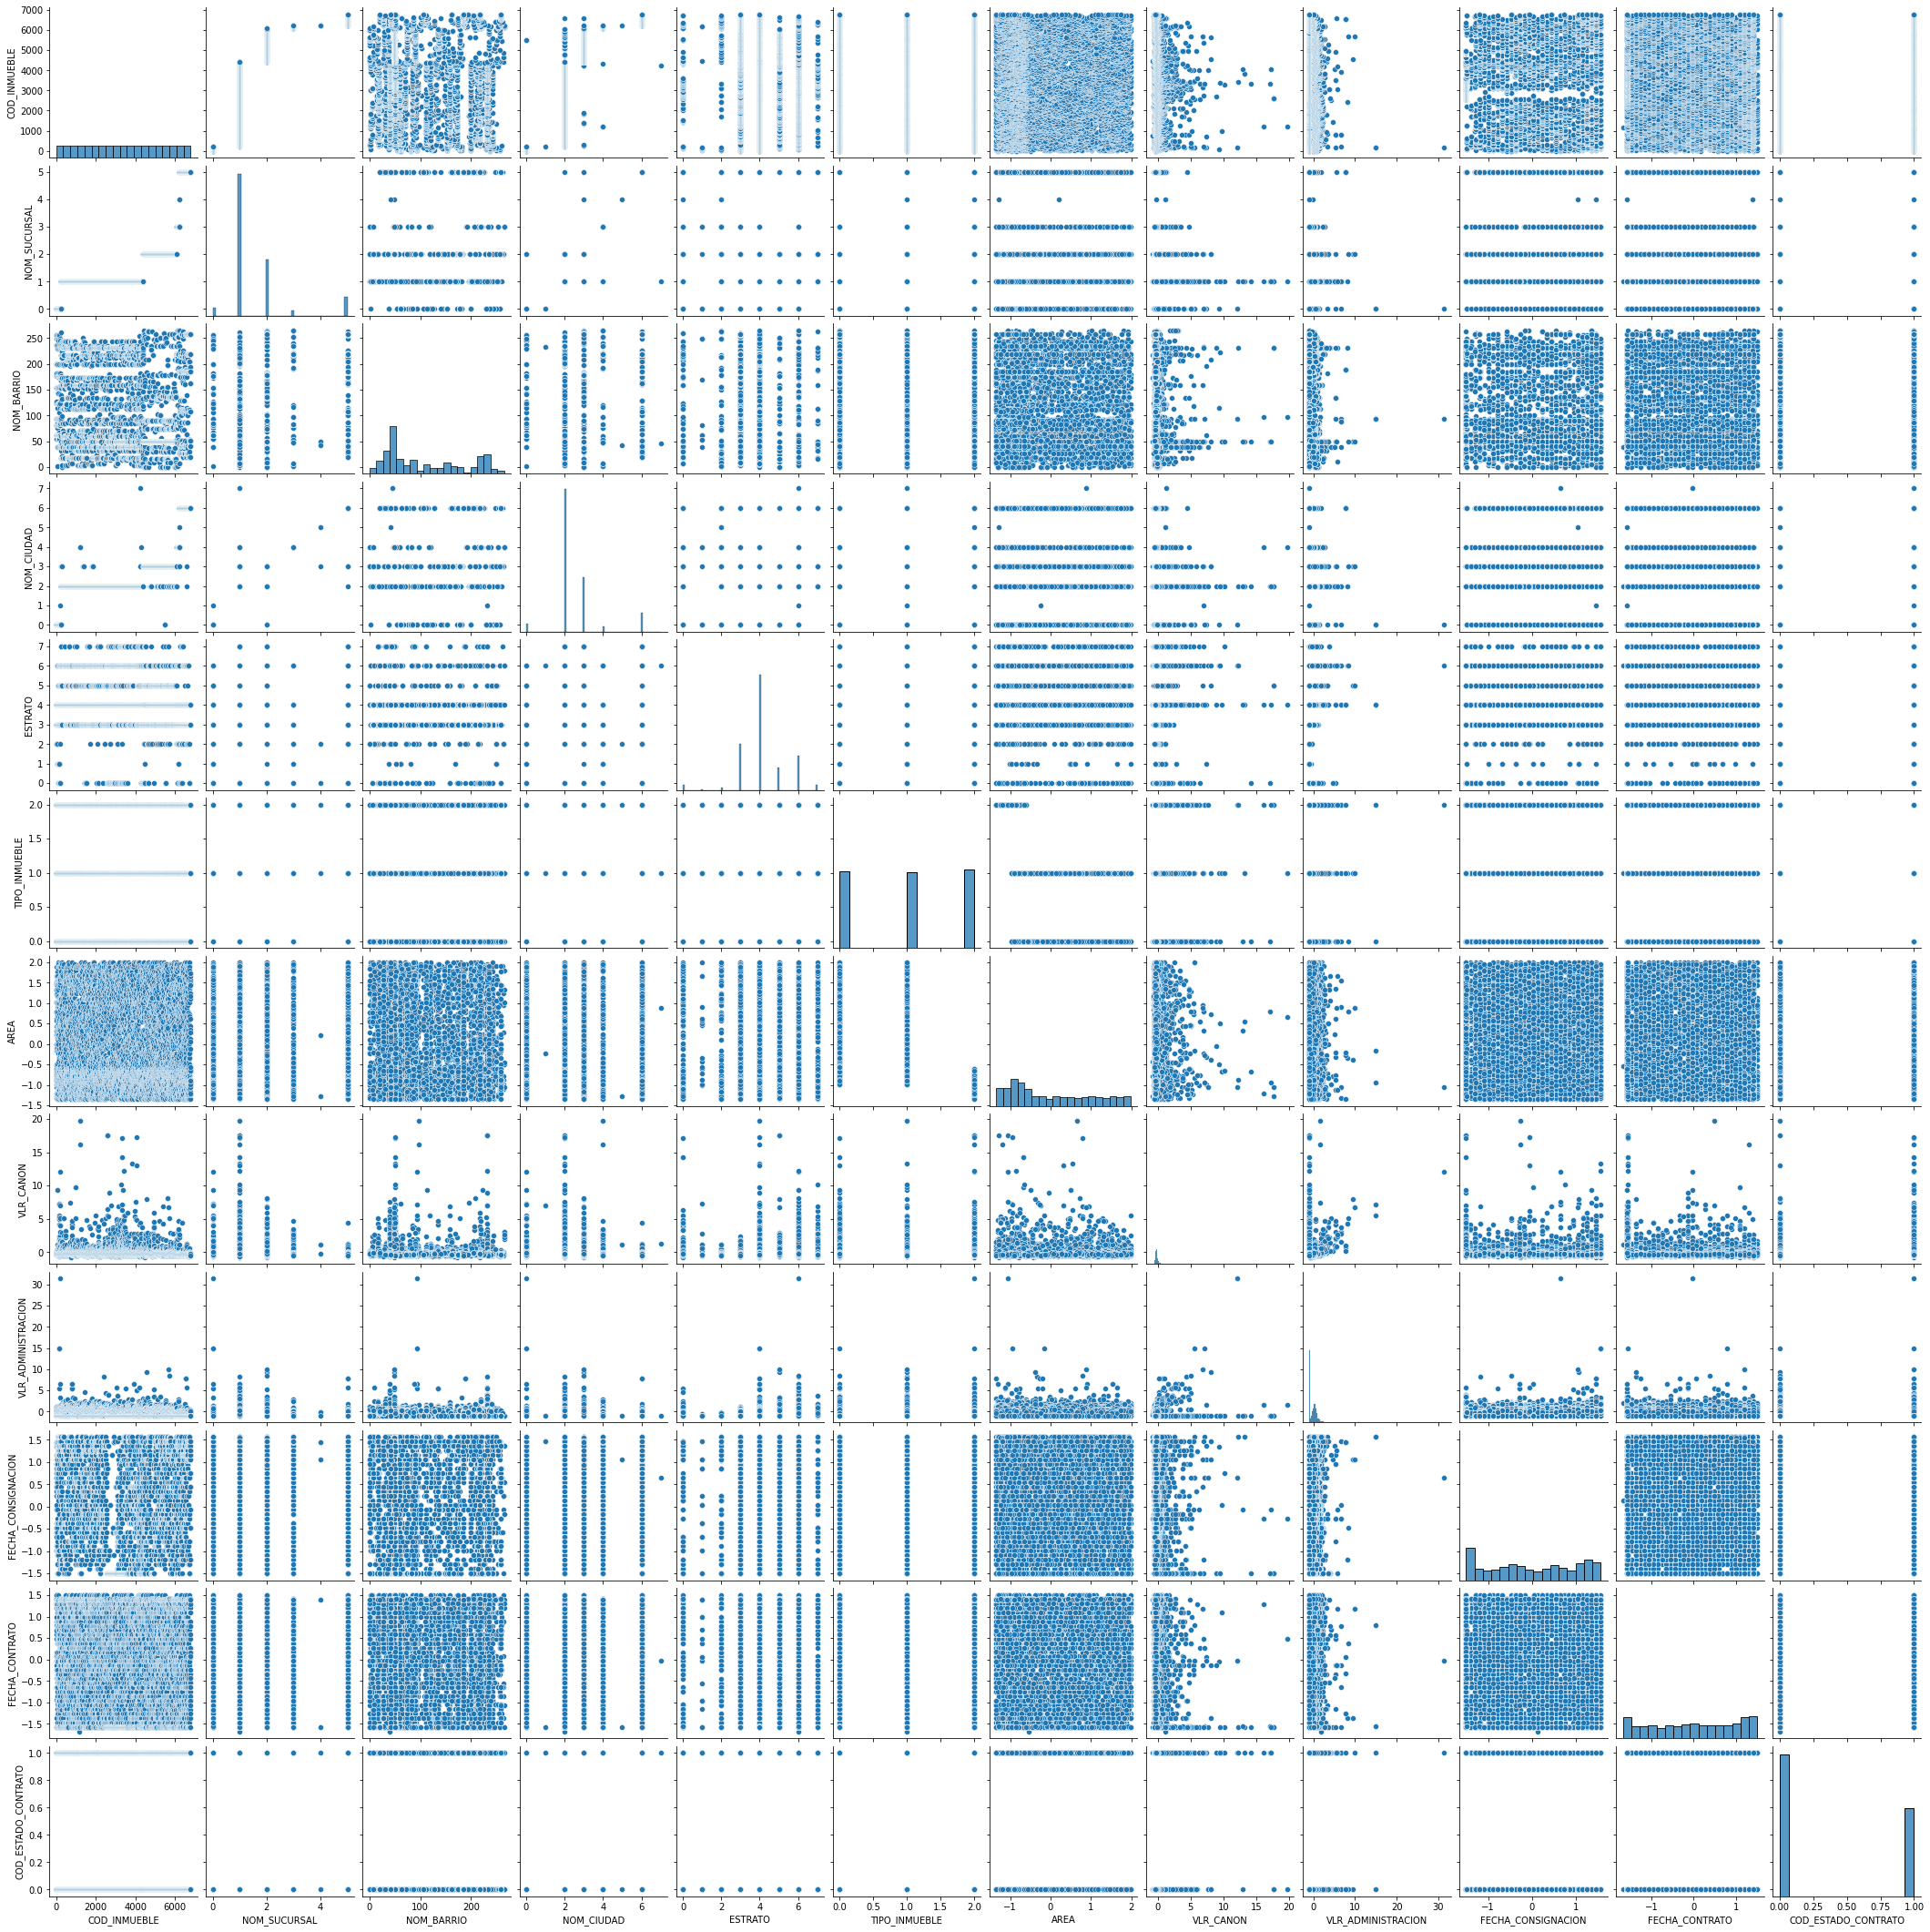

In [ ]:
sns.pairplot(data)

## Logistic Regression: 61.89%

In [ ]:
logistic_regression = LogisticRegression(solver='lbfgs', max_iter=6800)
logistic_regression.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6800,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_predict = logistic_regression.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_predict)
print('Exactitud= ' + str(100*accuracy) + "%")

Exactitud= 61.89634864546525%


## Decision Tree Classifier: 63.01%

In [ ]:
max_depth_lista = list(range(1, 10))

accuracy = []

for depth in max_depth_lista:
  arbol_clas = DecisionTreeClassifier(max_depth=depth, random_state=0)
  arbol_clas.fit(X_train, y_train)
  score = arbol_clas.score(X_test, y_test)
  accuracy.append(score)

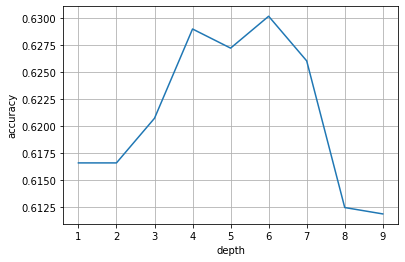

In [ ]:
plt.plot(max_depth_lista, accuracy)
plt.ylabel('accuracy')
plt.xlabel('depth')
plt.grid(True)
plt.show()

In [ ]:
arbol_clas = DecisionTreeClassifier(max_depth=6, random_state=0)

arbol_clas.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
accuracy = arbol_clas.score(X_test, y_test)
print(accuracy*100)

63.01531213191991


## SVM

### Linear: 62.98%

En este caso, las ejecuciones con el kernel linear, tomaron 10 minutos aproxiaproximadamente

In [ ]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

print('Accuracy: ', 100*(metrics.accuracy_score(y_test, y_predict)))

print('Precision: ', 100*(metrics.precision_score(y_test, y_predict)))

print('Recall: ', metrics.recall_score(y_test, y_predict))

Accuracy:  62.19081272084806
Precision:  66.66666666666666
Recall:  0.07207207207207207


In [ ]:
element, count = np.unique(y_test, return_counts=True)
element, count

(array([0, 1]), array([1032,  666]))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

print('Accuracy: ', 100*(metrics.accuracy_score(y_test, y_predict)))

Accuracy:  62.98749080206034


### Polynomial

Es posible que por recursos de mi equipo actual la ejecución del algoritmo con este kernel en grado 2, no se logre ejecutar. 

In [ ]:
clf = svm.SVC(kernel='poly', degree=2, gamma=100)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

print('Accuracy: ', 100*(metrics.accuracy_score(y_test, y_predict)))

print('Precision: ', 100*(metrics.precision_score(y_test, y_predict)))

print('Recall: ', metrics.recall_score(y_test, y_predict))

### Sigmoidal: 60.77%

La ejecución con este kernel se realizo en 1.09 segundos

In [25]:
clf = svm.SVC(kernel='sigmoid', gamma=200, C=10000, )
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

print('Accuracy: ', 100*(metrics.accuracy_score(y_test, y_predict)))

Accuracy:  60.7773851590106
